In [1]:
from facetorch import FaceAnalyzer
from facetorch.analyzer.utilizer import LandmarkDrawerTorch
from omegaconf import OmegaConf
from torch.nn.functional import cosine_similarity
from typing import Dict
import operator
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np

## Configure

In [2]:
path_img_input="../Dataset/Labeled_Faces_in_the_Wild/lfw-deepfunneled/lfw-deepfunneled/Bill_Gates/Bill_Gates_0010.jpg"
path_img_output="test_output.jpg"
path_config="../Pre-processing/gpu.config.yml"


cfg = OmegaConf.load(path_config)

## Startup

In [3]:
# initialize
analyzer = FaceAnalyzer(cfg.analyzer)


{"asctime": "2024-10-19 13:51:00,029", "levelname": "INFO", "message": "Initializing FaceAnalyzer"}
{"asctime": "2024-10-19 13:51:00,029", "levelname": "INFO", "message": "Initializing BaseReader"}
{"asctime": "2024-10-19 13:51:00,292", "levelname": "INFO", "message": "Initializing FaceDetector"}
{"asctime": "2024-10-19 13:51:00,924", "levelname": "INFO", "message": "Initializing FaceUnifier"}
{"asctime": "2024-10-19 13:51:00,938", "levelname": "INFO", "message": "Initializing FacePredictor objects"}
{"asctime": "2024-10-19 13:51:00,939", "levelname": "INFO", "message": "Initializing FacePredictor embed"}
{"asctime": "2024-10-19 13:51:01,173", "levelname": "INFO", "message": "Initializing FacePredictor verify"}
{"asctime": "2024-10-19 13:51:02,979", "levelname": "INFO", "message": "Initializing FacePredictor au"}
{"asctime": "2024-10-19 13:51:03,686", "levelname": "INFO", "message": "Initializing FacePredictor va"}
{"asctime": "2024-10-19 13:51:03,737", "levelname": "INFO", "message": 

## Inference

In [4]:
response = analyzer.run(
        path_image=path_img_input,
        batch_size=cfg.batch_size,
        fix_img_size=cfg.fix_img_size,
        return_img_data=cfg.return_img_data,
        include_tensors=cfg.include_tensors,
        path_output=path_img_output,
    )


{"asctime": "2024-10-19 13:51:04,023", "levelname": "INFO", "message": "Running FaceAnalyzer"}
{"asctime": "2024-10-19 13:51:04,023", "levelname": "INFO", "message": "Reading image", "input": "../Dataset/Labeled_Faces_in_the_Wild/lfw-deepfunneled/lfw-deepfunneled/Bill_Gates/Bill_Gates_0010.jpg"}
{"asctime": "2024-10-19 13:51:04,100", "levelname": "INFO", "message": "Detecting faces"}
{"asctime": "2024-10-19 13:51:04,937", "levelname": "INFO", "message": "Number of faces: 1"}
{"asctime": "2024-10-19 13:51:04,937", "levelname": "INFO", "message": "Unifying faces"}
{"asctime": "2024-10-19 13:51:04,951", "levelname": "INFO", "message": "Predicting facial features"}
{"asctime": "2024-10-19 13:51:04,952", "levelname": "INFO", "message": "Running FacePredictor: embed"}
c:\Users\46737\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1541: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT

In [5]:
response.faces[0].tensor.shape

torch.Size([3, 380, 380])

## Output image

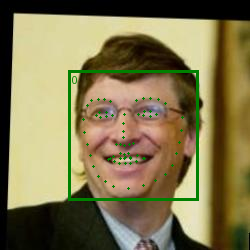

In [6]:
pil_image = torchvision.transforms.functional.to_pil_image(response.img)
pil_image

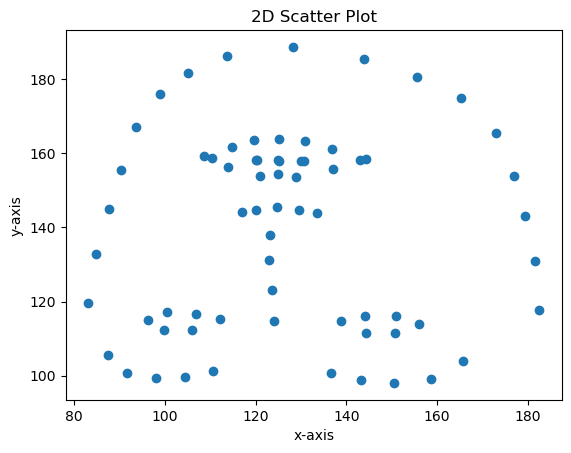

In [7]:


pts = [face.preds["align"].other["lmk3d"].cpu() for face in response.faces]


# data = normalize(pts[0])
data = pts[0]

norm = np.linalg.norm(data)  # Calculate the L2 norm of the data
normalized_data = data / norm

# Extract the first two columns for 2D scatter plot
x = data[0,:]  # First column (x)
y = data[1,:]  # Second column (y)
z = data[2,:]  # Third column (z)

# Create the 2D scatter plot
plt.scatter(x, y)
# print(len(z))

# Add labels and title
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('2D Scatter Plot')

# Display the plot
plt.show()


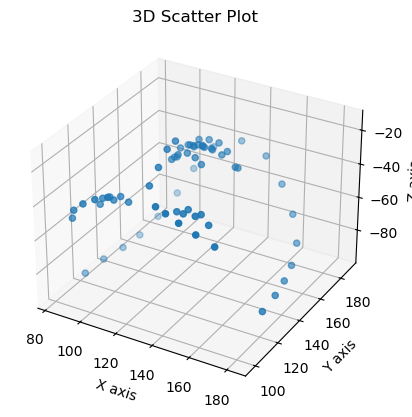

In [8]:
data = pts[0]

# Extract the three columns for 3D scatter plot
x = data[0,:]  # First column (x)
y = data[1,:]  # Second column (y)
z = data[2,:]  # Third column (z)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Create the 3D scatter plot
ax.scatter(x, y, z)

# Add labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.title('3D Scatter Plot')

# Display the plot
plt.show()

## Rotation

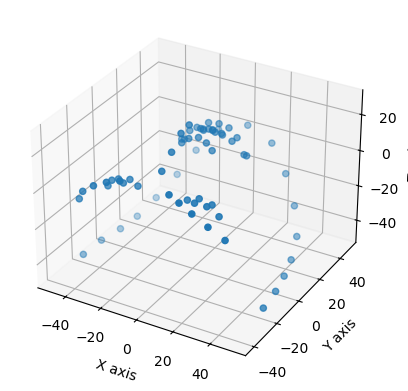

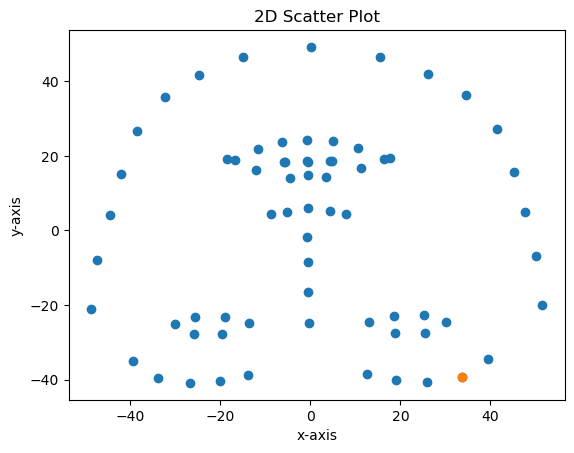

In [9]:
from scipy.spatial.transform import Rotation as R

def rotate_face(pts):
    data = pts[0]

    x = data[0, :]
    y = data[1, :]
    z = data[2, :]

    face_tensor = torch.stack([x, y, z], dim=1).to('cuda:0')
    # Väldigt hustler-lösning, får inte skiten att se bra ut

    sum_vectors = torch.sum(face_tensor, dim=0)
    centroid = sum_vectors / face_tensor.shape[0]
    face_tensor_orgin = (face_tensor - centroid).cpu().numpy()


    P1 = face_tensor_orgin[0]
    P2 = face_tensor_orgin[16]

    y1 = P1[1]
    y2 = P2[1]

    while abs(y1 - y2) > 1:
        r = R.from_euler('z', -0.1, degrees=True)
        face_tensor_orgin =  face_tensor_orgin @ r.as_matrix().T
        P1 = face_tensor_orgin[0]
        P2 = face_tensor_orgin[16]
        y1 = P1[1]
        y2 = P2[1]



    ### VET INTE OM DETTA FUNKAR ###
    z1 = P1[2]
    z2 = P2[2]
    x = face_tensor_orgin[33][0]

    i = 0.1
    if x > 0:
        i = -0.1

    while abs(z1 - z2) > 1:
        r = R.from_euler('y', i, degrees=True)
        face_tensor_orgin =  face_tensor_orgin @ r.as_matrix().T
        P1 = face_tensor_orgin[0]
        P2 = face_tensor_orgin[16]
        z1 = P1[2]
        z2 = P2[2]

    ### VET INTE OM DETTA FUNKAR SLUT ###

    if face_tensor_orgin[25][1] > 0:
        r = R.from_euler('z', 180, degrees=True)
        face_tensor_orgin =  face_tensor_orgin @ r.as_matrix().T
    
    return face_tensor_orgin

face_tensor_orgin = rotate_face(pts)
x = face_tensor_orgin[:,0]  # First column (x)
y = face_tensor_orgin[:,1]  # Second column (y)
z = face_tensor_orgin[:,2]  # Third column (z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Create the 3D scatter plot
ax.scatter(x, y, z)


fig = plt.figure()


# Create the 3D scatter plot
plt.scatter(x, y)
plt.scatter(x[25], y[25])
# print(len(z))
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
# Add labels and title
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('2D Scatter Plot')

# Display the plot
plt.show()





## FFT

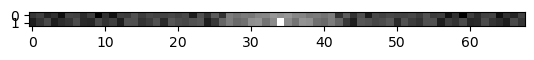

In [10]:
arr = response.faces[0].preds["align"].other["lmk3d"].cpu().numpy()

arrTwoDim = arr[:-1]

norm = np.linalg.norm(arrTwoDim)  # Calculate the L2 norm of the data
normalized_data = arrTwoDim / norm
transformed = np.fft.fft2(normalized_data)
transformedShifted = np.fft.fftshift(transformed)
logAbs = np.log(np.abs(transformedShifted))
plt.imshow(logAbs, cmap='gray')
plt.show()


(3, 68)


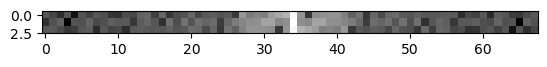

torch.Size([3, 68])

In [11]:
arr = response.faces[0].preds["align"].other["lmk3d"].cpu().numpy()

print(arr.shape)
norm = np.linalg.norm(arr)  # Calculate the L2 norm of the data
normalized_data = arr / norm
transformed = np.fft.fftn(normalized_data)
transformedShifted = np.fft.fftshift(transformed)
logAbs = np.log(np.abs(transformedShifted))
plt.imshow(logAbs, cmap='gray')
plt.show()
logAbs = torch.from_numpy(logAbs)

logAbs.shape

In [12]:
face1 = '../Pre-processing/dataset/face_dataset/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee0.jpg'
face2 = '../Pre-processing/dataset/face_dataset/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee2.jpg'
face3 = '../Pre-processing/dataset/face_dataset/John_Paul_II/John_Paul_II3.jpg'

analyzer = FaceAnalyzer(cfg.analyzer)

response1 = analyzer.run(
        path_image=face1,
        batch_size=cfg.batch_size,
        fix_img_size=cfg.fix_img_size,
        return_img_data=cfg.return_img_data,
        include_tensors=cfg.include_tensors,
        path_output=path_img_output,
    )

analyzer = FaceAnalyzer(cfg.analyzer)
response2 = analyzer.run(
        path_image=face2,
        batch_size=cfg.batch_size,
        fix_img_size=cfg.fix_img_size,
        return_img_data=cfg.return_img_data,
        include_tensors=cfg.include_tensors,
        path_output=path_img_output,
    )

analyzer = FaceAnalyzer(cfg.analyzer)
response3 = analyzer.run(
        path_image=face3,
        batch_size=cfg.batch_size,
        fix_img_size=cfg.fix_img_size,
        return_img_data=cfg.return_img_data,
        include_tensors=cfg.include_tensors,
        path_output=path_img_output,
    )

{"asctime": "2024-10-19 13:51:18,539", "levelname": "INFO", "message": "Initializing FaceAnalyzer"}
{"asctime": "2024-10-19 13:51:18,539", "levelname": "INFO", "message": "Initializing BaseReader"}
{"asctime": "2024-10-19 13:51:18,548", "levelname": "INFO", "message": "Initializing FaceDetector"}
{"asctime": "2024-10-19 13:51:18,757", "levelname": "INFO", "message": "Initializing FaceUnifier"}
{"asctime": "2024-10-19 13:51:18,766", "levelname": "INFO", "message": "Initializing FacePredictor objects"}
{"asctime": "2024-10-19 13:51:18,767", "levelname": "INFO", "message": "Initializing FacePredictor embed"}
{"asctime": "2024-10-19 13:51:18,932", "levelname": "INFO", "message": "Initializing FacePredictor verify"}
{"asctime": "2024-10-19 13:51:22,273", "levelname": "INFO", "message": "Initializing FacePredictor au"}
{"asctime": "2024-10-19 13:51:22,756", "levelname": "INFO", "message": "Initializing FacePredictor va"}
{"asctime": "2024-10-19 13:51:22,794", "levelname": "INFO", "message": 

In [13]:
pts1 = [face.preds["align"].other["lmk3d"].cpu() for face in response1.faces]
face_tensor_orgin1 = rotate_face(pts1)

pts2 = [face.preds["align"].other["lmk3d"].cpu() for face in response2.faces]
face_tensor_orgin2 = rotate_face(pts2)

pts3 = [face.preds["align"].other["lmk3d"].cpu() for face in response3.faces]
face_tensor_orgin3 = rotate_face(pts3)

In [14]:
def fft_func(arr):
    norm = np.linalg.norm(arr)  # Calculate the L2 norm of the data
    normalized_data = arr / norm
    transformed = np.fft.fftn(normalized_data)

    magnintude = np.abs(transformed)

    transformed_array = np.zeros(shape=(face_tensor_orgin1.shape[0]-1, face_tensor_orgin1.shape[1]))
    for i in range(0,3):
        background_value = magnintude[:,i][0]
        column = magnintude[:,i][1:]

        # column = column / background_value

        transformed_array[:,i] = column


    return transformed_array


def pre_processing(arr, name):
    fft = fft_func(arr)
    flat_list = fft.reshape(-1)
    return flat_list

In [19]:
from torch.nn import CosineSimilarity

cos = CosineSimilarity(dim=0)


cos(torch.from_numpy(pre_processing(face_tensor_orgin2, '')), torch.from_numpy(pre_processing(face_tensor_orgin3, '')))


# COSINE SIMILARITY IS NOT A GOOD ESTIMATE OF FFT, TRY WITH CNN IF RESULTS ARE INTERESTING #

tensor(0.8092, dtype=torch.float64)

In [16]:

data = pre_processing(face_tensor_orgin1, 'hej')

In [17]:
import pandas as pd

columns = [f'feature_{i}' for i in range(1, 202)] + ['label']
df = pd.DataFrame(columns=columns)

df.loc[len(df)] = data.tolist() + ['label']

df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_193,feature_194,feature_195,feature_196,feature_197,feature_198,feature_199,feature_200,feature_201,label
0,4.47779,1.136173,2.910712,2.246347,2.569862,1.350876,2.84437,1.356934,2.280391,1.019971,...,2.84437,2.280391,1.356934,2.246347,1.350876,2.569862,4.47779,2.910712,1.136173,label
